# Team AIesthetics - ML Model on Costa Rican Household Poverty Level Dataset
<font size=3>

A LightGBM based efficient Machine Learning model on Costa Rican Household Poverty Level Dataset. Contributors - Jyotisman Rath, Abhinandan Mohanty, Mohammed Hadi Dadan. This is our submission to BVEST Beat The Base Hackathon on 5th Nov 2020.

Primary aim is to develop an efficient machine learning model that can predict the poverty level of households using both individual and household characteristics based on social and economic factors.</font>

### Problem and Data Explanation
The data for this competition is provided in two files: train.csv and test.csv. The training set has 9557 rows and 143 columns while the testing set has 23856 rows and 142 columns.

The additional column 'Target' in the dataset represents the poverty level on a 1-4 scale and is the label for the competition.The poverty levels as follows:
<br>
<b>
<br>1 = extreme poverty 
<br>2 = moderate poverty 
<br>3 = vulnerable households 
<br>4 = non vulnerable households</b><br>

This can be regarded as supervised multi-class classification problem.

## Exploratory Data Analysis (Reading the data and cleaning it up)

In [ ]:
# Importing the libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
%matplotlib inline

In [ ]:
# Import train and test data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
# Check number of rows and columns in both
print("train set has", train.shape[0], "rows, and", train.shape[1], "features")
print("test set has", test.shape[0], "rows, and", test.shape[1], "features")

train set has 9557 rows, and 143 features
test set has 23856 rows, and 142 features


In [ ]:
# View the data in Target
target = train['Target']
target.value_counts()

4    5996
2    1597
3    1209
1     755
Name: Target, dtype: int64

### Missing Values and Outliers
Only 1 outlier value 'rez_esc' was found in test set. The value was changed to 5 based on host's answer on Kaggle's discussion forum.

In [ ]:
# Modify outliers
test.loc[test['rez_esc'] == 99.0 , 'rez_esc'] = 5

In [ ]:
# Check for missing values
null = train.isnull().sum().values
df_null = pd.DataFrame(null, index=train.columns, columns=['Count'])
df_null = df_null.sort_values(by=['Count'], ascending=False)  #sort the columns with missing values in descending order

count_missing = df_null[df_null['Count']>0].shape[0] #count of missing values

print("We got", count_missing, "rows which have missing value in train set")
df_null.head(count_missing+1)

We got 5 rows which have missing value in train set


,Count
rez_esc,7928
v18q1,7342
v2a1,6860
SQBmeaned,5
meaneduc,5
Id,0


<ul>
    <li><b>rez_esc</b> represents "years behind in school", missing value could be filled as 0<br>
    <li><b>v18q1</b> depends on v18q<br>
    <li><b>v2a1</b> depends on tipovivi3<br>
    <li><b>meaneduc</b> represents "average years of education for adults (18+)", missing value could be filled as 0<br>
    <li>We do not really need <b>SQBmeaned</b> features for polynomial in our case, and we will use fillna as 0 after at the last step of feature engineering
</ul>

In [ ]:
#Fill missing values
def repalce(x):
    if x['v18q'] == 0:
        return x['v18q']
    else:
        return x['v18q1']

train['v18q1'] = train.apply(lambda x : repalce(x),axis=1)
test['v18q1'] = test.apply(lambda x : repalce(x),axis=1)

train['v2a1'] = train['v2a1'].fillna(value=train['tipovivi3'])
test['v2a1'] = test['v2a1'].fillna(value=test['tipovivi3'])

### Feature Engineering (Important step !)
Replaced object value, because some labels were generated whenever continuous variables have 1 or 0. The rule is to have being yes=1 and no=0

In [ ]:
cols = ['edjefe', 'edjefa']
train[cols] = train[cols].replace({'no': 0, 'yes':1}).astype(float)
test[cols] = test[cols].replace({'no': 0, 'yes':1}).astype(float)

In [ ]:
# Orignial data lost one feature both for roof and electricity, so we manually add new feature
train['roof_waste_material'] = np.nan
test['roof_waste_material'] = np.nan
train['electricity_other'] = np.nan
test['electricity_other'] = np.nan

def fill_roof_exception(x):
    if (x['techozinc'] == 0) and (x['techoentrepiso'] == 0) and (x['techocane'] == 0) and (x['techootro'] == 0):
        return 1
    else:
        return 0
    
def fill_no_electricity(x):
    if (x['public'] == 0) and (x['planpri'] == 0) and (x['noelec'] == 0) and (x['coopele'] == 0):
        return 1
    else:
        return 0

train['roof_waste_material'] = train.apply(lambda x : fill_roof_exception(x),axis=1)
test['roof_waste_material'] = test.apply(lambda x : fill_roof_exception(x),axis=1)
train['electricity_other'] = train.apply(lambda x : fill_no_electricity(x),axis=1)
test['electricity_other'] = test.apply(lambda x : fill_no_electricity(x),axis=1)

In [ ]:
def owner_is_adult(x):
    if x['age'] <= 19:
        return 0
    else:
        return 1

train['head<18'] = train.apply(lambda x : owner_is_adult(x),axis=1)
test['head<18'] = test.apply(lambda x : owner_is_adult(x),axis=1)

In [ ]:
# More feature engineering
train['adult'] = train['hogar_adul'] - train['hogar_mayor']
train['dependency_count'] = train['hogar_nin'] + train['hogar_mayor']
train['dependency'] = train['dependency_count'] / train['adult']
train['child_percent'] = train['hogar_nin']/train['hogar_total']
train['elder_percent'] = train['hogar_mayor']/train['hogar_total']
train['adult_percent'] = train['hogar_adul']/train['hogar_total']
test['adult'] = test['hogar_adul'] - test['hogar_mayor']
test['dependency_count'] = test['hogar_nin'] + test['hogar_mayor']
test['dependency'] = test['dependency_count'] / test['adult']
test['child_percent'] = test['hogar_nin']/test['hogar_total']
test['elder_percent'] = test['hogar_mayor']/test['hogar_total']
test['adult_percent'] = test['hogar_adul']/test['hogar_total']

train['rent_per_adult'] = train['v2a1']/train['hogar_adul']
train['rent_per_person'] = train['v2a1']/train['hhsize']
test['rent_per_adult'] = test['v2a1']/test['hogar_adul']
test['rent_per_person'] = test['v2a1']/test['hhsize']

train['overcrowding_room_and_bedroom'] = (train['hacdor'] + train['hacapo'])/2
test['overcrowding_room_and_bedroom'] = (test['hacdor'] + test['hacapo'])/2

train['no_appliances'] = train['refrig'] + train['computer'] + train['television']
test['no_appliances'] = test['refrig'] + test['computer'] + test['television']

train['r4h1_percent_in_male'] = train['r4h1'] / train['r4h3']
train['r4m1_percent_in_female'] = train['r4m1'] / train['r4m3']
train['r4h1_percent_in_total'] = train['r4h1'] / train['hhsize']
train['r4m1_percent_in_total'] = train['r4m1'] / train['hhsize']
train['r4t1_percent_in_total'] = train['r4t1'] / train['hhsize']
test['r4h1_percent_in_male'] = test['r4h1'] / test['r4h3']
test['r4m1_percent_in_female'] = test['r4m1'] / test['r4m3']
test['r4h1_percent_in_total'] = test['r4h1'] / test['hhsize']
test['r4m1_percent_in_total'] = test['r4m1'] / test['hhsize']
test['r4t1_percent_in_total'] = test['r4t1'] / test['hhsize']

train['rent_per_room'] = train['v2a1']/train['rooms']
train['bedroom_per_room'] = train['bedrooms']/train['rooms']
train['elder_per_room'] = train['hogar_mayor']/train['rooms']
train['adults_per_room'] = train['adult']/train['rooms']
train['child_per_room'] = train['hogar_nin']/train['rooms']
train['male_per_room'] = train['r4h3']/train['rooms']
train['female_per_room'] = train['r4m3']/train['rooms']
train['room_per_person_household'] = train['hhsize']/train['rooms']

test['rent_per_room'] = test['v2a1']/test['rooms']
test['bedroom_per_room'] = test['bedrooms']/test['rooms']
test['elder_per_room'] = test['hogar_mayor']/test['rooms']
test['adults_per_room'] = test['adult']/test['rooms']
test['child_per_room'] = test['hogar_nin']/test['rooms']
test['male_per_room'] = test['r4h3']/test['rooms']
test['female_per_room'] = test['r4m3']/test['rooms']
test['room_per_person_household'] = test['hhsize']/test['rooms']

train['rent_per_bedroom'] = train['v2a1']/train['bedrooms']
train['edler_per_bedroom'] = train['hogar_mayor']/train['bedrooms']
train['adults_per_bedroom'] = train['adult']/train['bedrooms']
train['child_per_bedroom'] = train['hogar_nin']/train['bedrooms']
train['male_per_bedroom'] = train['r4h3']/train['bedrooms']
train['female_per_bedroom'] = train['r4m3']/train['bedrooms']
train['bedrooms_per_person_household'] = train['hhsize']/train['bedrooms']

test['rent_per_bedroom'] = test['v2a1']/test['bedrooms']
test['edler_per_bedroom'] = test['hogar_mayor']/test['bedrooms']
test['adults_per_bedroom'] = test['adult']/test['bedrooms']
test['child_per_bedroom'] = test['hogar_nin']/test['bedrooms']
test['male_per_bedroom'] = test['r4h3']/test['bedrooms']
test['female_per_bedroom'] = test['r4m3']/test['bedrooms']
test['bedrooms_per_person_household'] = test['hhsize']/test['bedrooms']

train['tablet_per_person_household'] = train['v18q1']/train['hhsize']
train['phone_per_person_household'] = train['qmobilephone']/train['hhsize']
test['tablet_per_person_household'] = test['v18q1']/test['hhsize']
test['phone_per_person_household'] = test['qmobilephone']/test['hhsize']

train['age_12_19'] = train['hogar_nin'] - train['r4t1']
test['age_12_19'] = test['hogar_nin'] - test['r4t1']    

train['escolari_age'] = train['escolari']/train['age']
test['escolari_age'] = test['escolari']/test['age']

train['rez_esc_escolari'] = train['rez_esc']/train['escolari']
train['rez_esc_r4t1'] = train['rez_esc']/train['r4t1']
train['rez_esc_r4t2'] = train['rez_esc']/train['r4t2']
train['rez_esc_r4t3'] = train['rez_esc']/train['r4t3']
train['rez_esc_age'] = train['rez_esc']/train['age']
test['rez_esc_escolari'] = test['rez_esc']/test['escolari']
test['rez_esc_r4t1'] = test['rez_esc']/test['r4t1']
test['rez_esc_r4t2'] = test['rez_esc']/test['r4t2']
test['rez_esc_r4t3'] = test['rez_esc']/test['r4t3']
test['rez_esc_age'] = test['rez_esc']/test['age']

In [ ]:
train['dependency'] = train['dependency'].replace({np.inf: 0})
test['dependency'] = test['dependency'].replace({np.inf: 0})

print("train set has", train.shape[0], "rows, and", train.shape[1], "features")
print("test set has", test.shape[0], "rows, and", test.shape[1], "features")

train set has 9557 rows, and 184 features
test set has 23856 rows, and 183 features


In [ ]:
# Aggregate train and test
df_train = pd.DataFrame()
df_test = pd.DataFrame()

aggr_mean_list = ['rez_esc', 'dis', 'male', 'female', 'estadocivil1', 'estadocivil2', 'estadocivil3', 'estadocivil4', 'estadocivil5', 'estadocivil6', 'estadocivil7', 'parentesco2',
             'parentesco3', 'parentesco4', 'parentesco5', 'parentesco6', 'parentesco7', 'parentesco8', 'parentesco9', 'parentesco10', 'parentesco11', 'parentesco12',
             'instlevel1', 'instlevel2', 'instlevel3', 'instlevel4', 'instlevel5', 'instlevel6', 'instlevel7', 'instlevel8', 'instlevel9',]

other_list = ['escolari', 'age', 'escolari_age']

for item in aggr_mean_list:
    group_train_mean = train[item].groupby(train['idhogar']).mean()
    group_test_mean = test[item].groupby(test['idhogar']).mean()
    new_col = item + '_aggr_mean'
    df_train[new_col] = group_train_mean
    df_test[new_col] = group_test_mean

for item in other_list:
    for function in ['mean','std','min','max','sum']:
        group_train = train[item].groupby(train['idhogar']).agg(function)
        group_test = test[item].groupby(test['idhogar']).agg(function)
        new_col = item + '_' + function
        df_train[new_col] = group_train
        df_test[new_col] = group_test

print("new aggregate train set has", df_train.shape[0], "rows, and", df_train.shape[1], "features")
print("new aggregate test set has", df_test.shape[0], "rows, and", df_test.shape[1], "features")

new aggregate train set has 2988 rows, and 46 features
new aggregate test set has 7352 rows, and 46 features


In [ ]:
# merge train and test
df_test = df_test.reset_index()
df_train = df_train.reset_index()

train_agg = pd.merge(train, df_train, on='idhogar')
test = pd.merge(test, df_test, on='idhogar')

#fill all na as 0
train_agg.fillna(value=0, inplace=True)
test.fillna(value=0, inplace=True)
print("new train set has", train_agg.shape[0], "rows, and", train_agg.shape[1], "features")
print("new test set has", test.shape[0], "rows, and", test.shape[1], "features")

new train set has 9557 rows, and 230 features
new test set has 23856 rows, and 229 features


<b>Important note: while all members of a household should have the same label in the training data, there are errors where individuals in the same household have different labels. In these cases, we are told to use the label for the head of each household, which can be identified by the rows where parentesco1 == 1.0

In [ ]:
train = train_agg.query('parentesco1==1')

In [ ]:
submission = test[['Id']]

#Remove useless feature to reduce dimension
train.drop(columns=['Id', 'idhogar', 'tamhog', 'agesq', 'hogar_adul', 'SQBescolari', 'SQBage', 'SQBhogar_total', 'SQBedjefe', 'SQBhogar_nin', 'SQBovercrowding', 'SQBdependency', 'SQBmeaned'], inplace=True)
test.drop(columns=['Id', 'idhogar', 'tamhog', 'agesq', 'hogar_adul', 'SQBescolari', 'SQBage', 'SQBhogar_total', 'SQBedjefe', 'SQBhogar_nin', 'SQBovercrowding', 'SQBdependency', 'SQBmeaned'], inplace=True)

correlation = train.corr()
correlation = correlation['Target'].sort_values(ascending=False)
print("The most 20 positive feature: \n",correlation.head(20))
print('*'*40)

print("The most 20 negative feature: \n",correlation.tail(20))

The most 20 positive feature: 
 Target                  1.000000
escolari_mean           0.423626
escolari_max            0.373091
escolari                0.333791
meaneduc                0.331489
escolari_min            0.306693
cielorazo               0.295249
eviv3                   0.293540
instlevel8_aggr_mean    0.293307
epared3                 0.280947
escolari_age_min        0.276896
pisomoscer              0.275452
adult_percent           0.263882
etecho3                 0.261142
escolari_age_mean       0.258934
escolari_sum            0.256726
paredblolad             0.254469
edjefe                  0.235687
instlevel8              0.235102
escolari_age            0.232205
Name: Target, dtype: float64
****************************************
The most 20 negative feature: 
 child_percent       -0.263882
hogar_nin           -0.266309
dependency_count    -0.283908
dependency          -0.304563
child_per_room      -0.305541
child_per_bedroom   -0.308308
elimbasu5                 

## Visualization using PCA
<font size=3>Before the ML process takes place, a visualisation of the training set can be intuitive. We use the PCA technique to visualise the data set.

In [ ]:
# from sklearn.decomposition import PCA
# from sklearn.feature_selection import SelectKBest, chi2
# pca_t=train
# numeric_train_df = pca_t.drop(columns=['Target']).iloc[:]
# label_series =  train.Target.reset_index(drop=True)
# pca = PCA(n_components=3, whiten=True, svd_solver='auto', random_state=166446054) 
# pca_train_array = pca.fit_transform(numeric_train_df)
# pca_train_df = pd.DataFrame(pca_train_array)

# pca_train_df = pd.concat([pca_train_df, label_series], axis=1)
# pca_3d_plot(pca_train_df=pca_train_df)

## Model - LightGBM

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score

In [ ]:
y = train['Target']
train.drop(columns=['Target'], inplace=True)

#parameter value is copied from 
clf = lgb.LGBMClassifier(max_depth=9, learning_rate=0.01, objective='multiclass',
                             random_state=0, silent=True, metric='None', 
                             n_jobs=4, n_estimators=2500, class_weight='balanced',
                             colsample_bytree =  0.93, min_child_samples = 20, num_leaves = 21, subsample = 0.96)

## StratifiedKFold

In [ ]:
kfold = 5
kf = StratifiedKFold(n_splits=kfold, shuffle=True, random_state=0)
count=1
predicts_result = []
test_result = []
for train_index, test_index in kf.split(train, y):
    print("Running", count) #It will run for Kfold(5) number of times
    count = count+1
    X_train, X_val = train.iloc[train_index], train.iloc[test_index]
    y_train, y_val = y.iloc[train_index], y.iloc[test_index]
    clf.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=100) #fit the data
    test_result.append(f1_score(y_pred=clf.predict(X_val), y_true=y_val, average="macro"))
    predicts_result.append(clf.predict(test)) #predict for test data

Running 1
Running 2
Running 3
Running 4
Running 5


In [ ]:
for result in test_result:
    print(result)
print("Mean test f1: ", np.mean(test_result))

0.3446713641312855
0.39524074920817653
0.4118800326456611
0.3799985863725678
0.38548214146693016
Mean test f1:  0.3834545747649242


In [ ]:
train_predict = clf.predict(train)
test_f1 = f1_score(y_pred=train_predict, y_true=y, average="macro")
print("LGBM train f1: ", test_f1)

LGBM train f1:  0.8862684036899038


Text(0.5, 1.0, 'LightGBM feature importance')

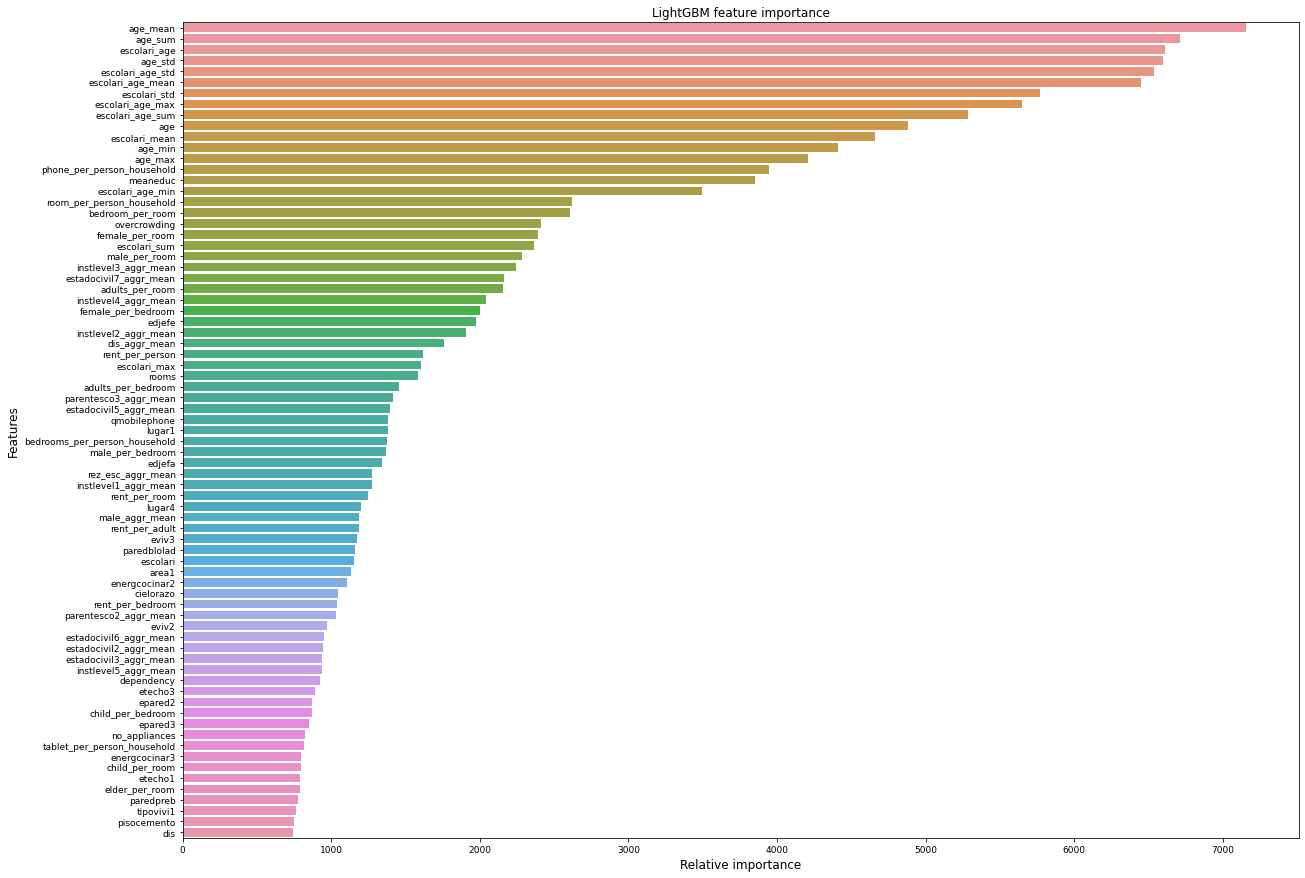

In [ ]:
#LightGBM feature importance
indices = np.argsort(clf.feature_importances_)[::-1]
indices = indices[:75]

# Visualise these with a barplot
plt.subplots(figsize=(20, 15))
g = sb.barplot(y=train.columns[indices], x = clf.feature_importances_[indices], orient='h')
g.set_xlabel("Relative importance",fontsize=12)
g.set_ylabel("Features",fontsize=12)
g.tick_params(labelsize=9)
g.set_title("LightGBM feature importance")

In [ ]:
submission['Target'] = [np.argmax(np.bincount(x)) for x in np.vstack(predicts_result).T]
submission.to_csv('submission.csv', index = False)

In [ ]:
submission

,Id,Target
0,ID_2f6873615,4
1,ID_1c78846d2,4
2,ID_e5442cf6a,4
3,ID_a8db26a79,4
4,ID_a62966799,4
...,...,...
23851,ID_a065a7cad,2
23852,ID_1a7c6953b,2
23853,ID_07dbb4be2,2
23854,ID_34d2ed046,4


## THE END